In [1]:
import numpy as np
import scipy.linalg
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import time 

In [2]:
# Best practice source:
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(72730)))

In [3]:
# Generate simulated data 
# Must have rows > cols 
rows=100
cols = 10
sigma_true = .5
x = np.random.normal(size=(rows, cols))
beta_true = np.multiply(np.random.normal(size=cols), np.random.uniform(-6,6,cols))
y = np.matmul(x, beta_true) + sigma_true*np.random.normal(size=rows)

In [4]:
# Use scipy qr decomposition to solve for betas 
decomp = scipy.linalg.qr(x)
print("Dimensions of Q: ", decomp[0].shape)
print("Dimensions of R: ", decomp[1].shape)

Dimensions of Q:  (100, 100)
Dimensions of R:  (100, 10)


In [5]:
# Verify that Q is orthogonal 
print("Q'Q: ", np.matmul(decomp[0], decomp[0].T).round(10))
print("Det of Q: ", scipy.linalg.det(decomp[0]))

Q'Q:  [[ 1. -0.  0. ... -0.  0. -0.]
 [-0.  1. -0. ... -0.  0. -0.]
 [ 0. -0.  1. ... -0.  0. -0.]
 ...
 [-0. -0. -0. ...  1. -0.  0.]
 [ 0.  0.  0. ... -0.  1.  0.]
 [-0. -0. -0. ...  0.  0.  1.]]
Det of Q:  1.0000000000000029


In [6]:
# Verify that we can recover X 
np.allclose(np.dot(decomp[0], decomp[1]), x)

True

In [7]:
# Solve for beta using R%*%Beta = Q^t%*%y 
qty = np.matmul(decomp[0].T, y.reshape(-1,1))
# Need to use the linearly indepdentent part of R, corresponding QtY
beta_hat = scipy.linalg.solve_triangular(decomp[1][:cols, :cols], qty[:cols])

In [8]:
# Verify that we're close to the true beta 
print("Difference in Beta Hat vs Beta True:")
np.subtract(beta_hat, np.reshape(beta_true, (-1,1)))

Difference in Beta Hat vs Beta True:


array([[ 0.03062098],
       [-0.01686938],
       [-0.00668422],
       [ 0.10214225],
       [-0.02472997],
       [-0.03930336],
       [ 0.06000058],
       [-0.0130657 ],
       [-0.00876292],
       [-0.01727208]])

In [9]:
# Verify that we're close to the fitted beta from sklearn
lfit = LinearRegression() #L2 reg is 1/C
# need numpy 2dim array for X
# X = x.reshape((n,1)).copy()
lfit.fit(x,y)
print("Differences in sklearn vs backsolve: ")
np.subtract(beta_hat, np.reshape(lfit.coef_, (-1,1)))
# Looking good! 

Differences in sklearn vs backsolve: 


array([[ 2.50484113e-03],
       [-4.05947403e-03],
       [ 1.86747191e-03],
       [-3.68102959e-04],
       [-1.77282626e-04],
       [ 6.26297593e-04],
       [ 2.80990643e-03],
       [-1.11652546e-03],
       [ 4.49906040e-05],
       [ 8.06336569e-04]])

In [10]:
# Time the qr decomp as the size of a square matrix increases 
row_space = np.linspace(1, 2500, 2500, dtype=int)
outputs = np.zeros(row_space.shape[0])
for i in range(row_space.shape[0]):
    n = row_space[i]
    data = np.random.normal(size=(n,n))
    start = time.time()
    tmp = scipy.linalg.qr(data)
    outputs[i] = time.time() - start

Text(0.5, 1.0, 'Time to decompose an n x n matrix')

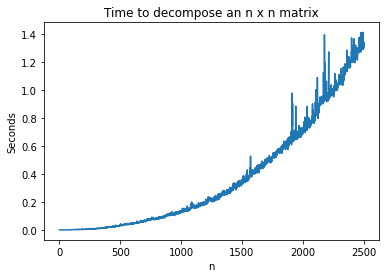

In [11]:
plt.plot(row_space, outputs)
plt.xlabel("n")
plt.ylabel("Seconds")
plt.title("Time to decompose an n x n matrix")